In [21]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/learning-agency-lab-automated-essay-scoring-2/sample_submission.csv
/kaggle/input/learning-agency-lab-automated-essay-scoring-2/train.csv
/kaggle/input/learning-agency-lab-automated-essay-scoring-2/test.csv
/kaggle/input/glove/glove.6B.100d.txt


In [ ]:
# !pip install pandas==2.1.4

In [22]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [23]:
train = pd.read_csv('/kaggle/input/learning-agency-lab-automated-essay-scoring-2/train.csv')
test = pd.read_csv('/kaggle/input/learning-agency-lab-automated-essay-scoring-2/test.csv')
sub = pd.read_csv('/kaggle/input/learning-agency-lab-automated-essay-scoring-2/sample_submission.csv')
train

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3
...,...,...,...
17302,ffd378d,"the story "" The Challenge of Exploing Venus "" ...",2
17303,ffddf1f,Technology has changed a lot of ways that we l...,4
17304,fff016d,If you don't like sitting around all day than ...,2
17305,fffb49b,"In ""The Challenge of Exporing Venus,"" the auth...",1


In [24]:
num_classes = len(train['score'].unique())
num_classes

6

In [25]:
test.head()

,essay_id,full_text
0,000d118,Many people have car where they live. The thin...
1,000fe60,I am a scientist at NASA that is discussing th...
2,001ab80,People always wish they had the same technolog...


In [26]:
sub.head()

,essay_id,score
0,000d118,3
1,000fe60,3
2,001ab80,4


In [27]:
!pip install -U -q sentencepiece

In [28]:
with open('./input.txt', 'w') as f:
    for line in train['full_text'].values:
        try:
            f.write(line)
        except:
            print("write error ---> ", line)

In [29]:
#write 가 잘 되었는지 확인
with open('./input.txt', 'r') as f:
    txt = f.read().split('\n')

print(len(txt))
print(txt[0])

137259
Many people have car where they live. The thing they don't know is that when you use a car alot of thing can happen like you can get in accidet or the smoke that the car has is bad to breath on if someone is walk but in VAUBAN,Germany they dont have that proble because 70 percent of vauban's families do not own cars,and 57 percent sold a car to move there. Street parkig ,driveways and home garages are forbidden on the outskirts of freiburd that near the French and Swiss borders. You probaly won't see a car in Vauban's streets because they are completely "car free" but If some that lives in VAUBAN that owns a car ownership is allowed,but there are only two places that you can park a large garages at the edge of the development,where a car owner buys a space but it not cheap to buy one they sell the space for you car for $40,000 along with a home. The vauban people completed this in 2006 ,they said that this an example of a growing trend in Europe,The untile states and some where 

In [30]:
import sentencepiece as spm

spm.SentencePieceTrainer.Train('--input=input.txt --model_prefix=spm --vocab_size=10000')
sp = spm.SentencePieceProcessor()
sp.Load('{}.model'.format('spm'))

sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=input.txt --model_prefix=spm --vocab_size=10000
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: input.txt
  input_format: 
  model_prefix: spm
  model_type: UNIGRAM
  vocab_size: 10000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_p

True

In [31]:
#tokenize& sequence 화
train_texts = [sp.encode_as_ids(t) for t in train['full_text'].values]
test_texts = [sp.encode_as_ids(t) for t in test['full_text'].values]

In [32]:
# train_texts[0]

In [33]:
# 가장 긴 문장 길이 알아보기 (train과 test데이터 모두에서)
max([len(s) for s in train_texts] + [len(s) for s in test_texts]) #각각의 문장들의 길이를 쭈우욱 출력

1824

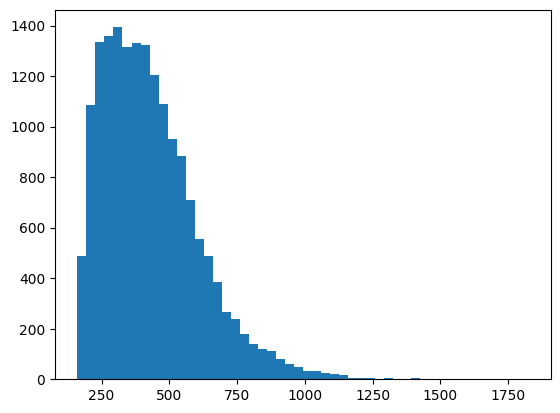

In [34]:
# 히스토그램 빈도수
plt.hist([len(s) for s in train_texts] + [len(s) for s in test_texts], bins=50); #간격 조정 50

In [35]:
max_len = 1824
train_texts = pad_sequences(train_texts, maxlen = max_len, truncating = 'post', padding = 'post')
test_texts = pad_sequences(test_texts, maxlen = max_len, truncating = 'post', padding = 'post')

In [36]:
train_texts = pd.DataFrame(train_texts)
test_texts = pd.DataFrame(test_texts)

In [37]:
train_x, val_x, train_y, val_y = train_test_split(train_texts, train['score'], test_size = 0.2, random_state = 42)

print(train_x.shape)
print(val_x.shape)
print(train_y.shape)
print(val_y.shape)

(13845, 1824)
(3462, 1824)
(13845,)
(3462,)


In [38]:
from tensorflow.keras.utils import to_categorical

train_y -= 1
val_y -= 1

# to_categorical 함수를 사용하여 원-핫 인코딩 적용
train_y = to_categorical(train_y, num_classes=num_classes)
val_y = to_categorical(val_y, num_classes=num_classes)

In [41]:
vocab_size = 10000
model2 = Sequential([
    Embedding(vocab_size+1, 100), # 10000개의 단어 사전 + padding(0값) 을 64개의 벡터로 임베딩한 다는 것.
    Dropout(0.2),
    Bidirectional(tf.keras.layers.LSTM(100)),
    Dropout(0.2),
    Dense(64, activation='relu'),
#     Dropout(0.2),
    Dense(num_classes, activation='softmax') #0~1사이의 값이 나오는 sigmoid
])

model2.compile(loss='categorical_crossentropy',optimizer=Adam(0.0001), metrics=['accuracy'])
model2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [42]:
%%time
num_epochs = 60
history = model2.fit(train_x, train_y, epochs=num_epochs, batch_size=512,
                validation_data=(val_x, val_y), verbose=1)

Epoch 1/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 573ms/step - accuracy: 0.2353 - loss: 1.7668 - val_accuracy: 0.3654 - val_loss: 1.6505
Epoch 2/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 559ms/step - accuracy: 0.3632 - loss: 1.5949 - val_accuracy: 0.3654 - val_loss: 1.4745
Epoch 3/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 560ms/step - accuracy: 0.3582 - loss: 1.4694 - val_accuracy: 0.3654 - val_loss: 1.4558
Epoch 4/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 561ms/step - accuracy: 0.3573 - loss: 1.4582 - val_accuracy: 0.3654 - val_loss: 1.4450
Epoch 5/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 561ms/step - accuracy: 0.3576 - loss: 1.4438 - val_accuracy: 0.3671 - val_loss: 1.4132
Epoch 6/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 560ms/step - accuracy: 0.3790 - loss: 1.3892 - val_accuracy: 0.4122 - val_loss: 1.3745
Epoch 7/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 560ms/step - accuracy: 0.3969 - loss: 1.3542 - val_accuracy: 0.4258 - val_loss: 1.3318
Epoch 8/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 560ms/step - accuracy: 0.4226 - loss: 1.3160 - val_accu

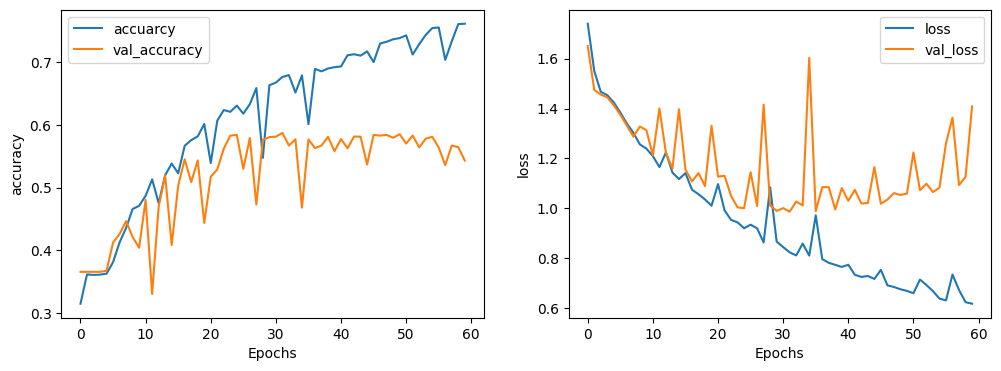

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4)) #ax1, ax2 두개의 축

ax1.plot(history.history['accuracy'], label = 'accuracy')
ax1.plot(history.history['val_accuracy'], label = 'val_accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('accuracy')
ax1.legend(['accuarcy', 'val_accuracy'])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_xlabel('Epochs')
ax2.set_ylabel('loss')
ax2.legend(['loss', 'val_loss'])
plt.show()

In [44]:
result = model2.predict(test_texts)
print(result)
print(result.argmax(1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
[[6.1406052e-01 3.8287774e-01 3.0496558e-03 9.0915401e-06 2.3720770e-06
  6.6531146e-07]
 [4.5677321e-03 1.9447351e-01 7.9233479e-01 8.3846366e-03 1.7066039e-04
  6.8584064e-05]
 [2.3869275e-04 1.0620112e-03 4.5095336e-02 6.2478673e-01 2.8988630e-01
  3.8930919e-02]]
[0 2 3]


In [45]:
sub['score'] = result.argmax(1)
sub['score'] += 1
sub.to_csv('submission.csv', index = False)